# Google Cloud Vertex AI

**Note:** This is separate from the `Google Generative AI` integration, it exposes [Vertex AI Generative API](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) on `Google Cloud`.


## Setting up

By default, Google Cloud [does not use](https://cloud.google.com/vertex-ai/docs/generative-ai/data-governance#foundation_model_development) customer data to train its foundation models as part of Google Cloud's AI/ML Privacy Commitment. More details about how Google processes data can also be found in [Google's Customer Data Processing Addendum (CDPA)](https://cloud.google.com/terms/data-processing-addendum).

To use `Vertex AI Generative AI` you must have the `google-cloud-aiplatform` Python package installed and either:
- Have credentials configured for your environment (gcloud, workload identity, etc...)
- Store the path to a service account JSON file as the GOOGLE_APPLICATION_CREDENTIALS environment variable

This codebase uses the `google.auth` library which first looks for the application credentials variable mentioned above, and then looks for system-level auth.

For more information, see:
- https://cloud.google.com/docs/authentication/application-default-credentials#GAC
- https://googleapis.dev/python/google-auth/latest/reference/google.auth.html#module-google.auth

In [ ]:
#!pip install langchain google-cloud-aiplatform

In [5]:
from langchain.llms import VertexAI

llm = VertexAI()
print(llm("What are some of the pros and cons of Python as a programming language?"))

 **Pros of Python:**

* **Easy to learn and use:** Python is known for its simple syntax and readability, making it a great choice for beginners. It also has a large and supportive community, with many resources available online.
* **Versatile:** Python can be used for a wide variety of tasks, including web development, data science, machine learning, and artificial intelligence.
* **Powerful:** Python has a rich library of built-in functions and modules, making it easy to perform complex tasks without having to write a lot of code.
* **Cross-platform:** Python can be run on a variety of operating systems


You can also use Gemini model (in preview) with VertexAI:

In [6]:
llm = VertexAI(model_name="gemini-pro")
print(llm("What are some of the pros and cons of Python as a programming language?"))

**Pros of Python:**

* **Easy to learn and use:** Python is known for its simplicity and readability, making it a great choice for beginners and experienced programmers alike. Its syntax is straightforward and intuitive, allowing developers to quickly pick up the language and start writing code.


* **Versatile:** Python is a general-purpose language that can be used for a wide range of applications, including web development, data science, machine learning, and scripting. Its extensive standard library and vast ecosystem of third-party modules make it suitable for a variety of tasks.


* **Cross-platform:** Python is compatible with multiple operating systems, including


## Using in a chain

In [ ]:
from langchain.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

In [ ]:
chain = prompt | llm

In [ ]:
question = "Who was the president in the year Justin Beiber was born?"
print(chain.invoke({"question": question}))

 Justin Bieber was born on March 1, 1994. Bill Clinton was the president of the United States from January 20, 1993, to January 20, 2001.
The final answer is Bill Clinton


## Code generation example

You can now leverage the `Codey API` for code generation within `Vertex AI`.

The model names are:
- `code-bison`: for code suggestion
- `code-gecko`: for code completion

In [ ]:
llm = VertexAI(model_name="code-bison", max_output_tokens=1000, temperature=0.3)

In [ ]:
question = "Write a python function that checks if a string is a valid email address"

In [ ]:
print(llm(question))

```python
import re

def is_valid_email(email):
    pattern = re.compile(r"[^@]+@[^@]+\.[^@]+")
    return pattern.match(email)
```


## Full generation info

We can use the `generate` method to get back extra metadata like [safety attributes](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/responsible-ai#safety_attribute_confidence_scoring) and not just text completions

In [ ]:
result = llm.generate([question])
result.generations

[[GenerationChunk(text='```python\nimport re\n\ndef is_valid_email(email):\n    pattern = re.compile(r"[^@]+@[^@]+\\.[^@]+")\n    return pattern.match(email)\n```', generation_info={'is_blocked': False, 'safety_attributes': {'Health': 0.1}})]]

## Asynchronous calls

With `agenerate` we can make asynchronous calls

In [ ]:
# If running in a Jupyter notebook you'll need to install nest_asyncio

# !pip install nest_asyncio

In [ ]:
import asyncio

# import nest_asyncio
# nest_asyncio.apply()

In [ ]:
asyncio.run(llm.agenerate([question]))

LLMResult(generations=[[GenerationChunk(text='```python\nimport re\n\ndef is_valid_email(email):\n    pattern = re.compile(r"[^@]+@[^@]+\\.[^@]+")\n    return pattern.match(email)\n```', generation_info={'is_blocked': False, 'safety_attributes': {'Health': 0.1}})]], llm_output=None, run=[RunInfo(run_id=UUID('caf74e91-aefb-48ac-8031-0c505fcbbcc6'))])

## Streaming calls

With `stream` we can stream results from the model

In [ ]:
import sys

In [ ]:
for chunk in llm.stream(question):
    sys.stdout.write(chunk)
    sys.stdout.flush()

```python
import re

def is_valid_email(email):
  """
  Checks if a string is a valid email address.

  Args:
    email: The string to check.

  Returns:
    True if the string is a valid email address, False otherwise.
  """

  # Check for a valid email address format.
  if not re.match(r"^[A-Za-z0-9\.\+_-]+@[A-Za-z0-9\._-]+\.[a-zA-Z]*$", email):
    return False

  # Check if the domain name exists.
  try:
    domain = email.split("@")[1]
    socket.gethostbyname(domain)
  except socket.gaierror:
    return False

  return True
```

## Multimodality

With Gemini, you can use LLM in a multimodal mode:

In [8]:
from langchain.chat_models import ChatVertexAI
from langchain.schema.messages import HumanMessage

llm = ChatVertexAI(model_name="gemini-ultra-vision")

image_message = {
    "type": "image_url",
    "image_url": {"url": "image_example.jpg"},
}
text_message = {
    "type": "text",
    "text": "What is shown in this image?",
}
message = HumanMessage(content=[text_message, image_message])

output = llm([message])
print(output.content)

 This is a Yorkshire Terrier.


Let's double-check it's a cat :)

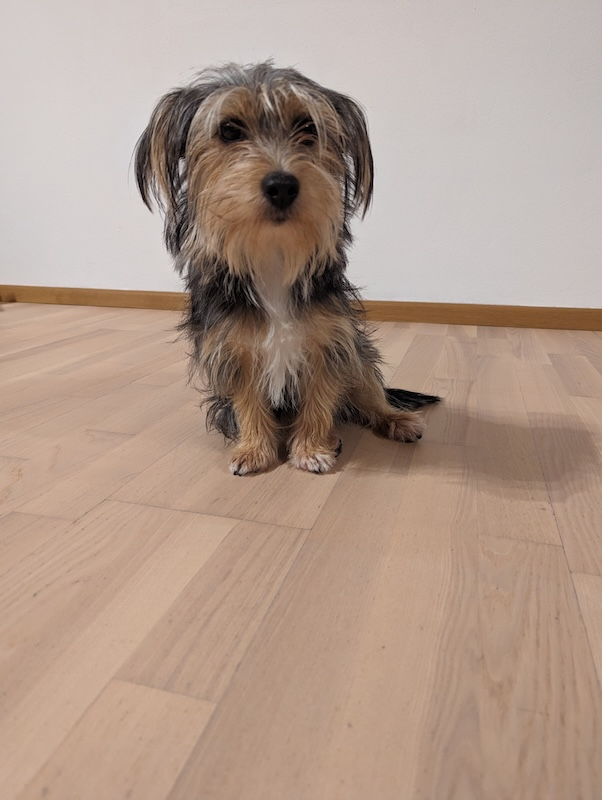

In [9]:
from vertexai.preview.generative_models import Image

i = Image.load_from_file("image_example.jpg")
i

You can also pass images as bytes:

In [18]:
import base64

with open("image_example.jpg", "rb") as image_file:
    image_bytes = image_file.read()

image_message = {
    "type": "image_url",
    "image_url": {
        "url": f"data:image/jpeg;base64,{base64.b64encode(image_bytes).decode('utf-8')}"
    },
}
text_message = {
    "type": "text",
    "text": "What is shown in this image?",
}
message = HumanMessage(content=[text_message, image_message])

output = llm([message])
print(output.content)

 This is a Yorkshire Terrier.


Please, note that you can also use the image stored in GCS (just point the `url` to the full GCS path, starting with `gs://` instead of a local one).

And you can also pass a history of a previous chat to the LLM:

In [ ]:
message2 = HumanMessage(content="And where the image is taken?")
output2 = llm([message, output, message2])
print(output2.content)

## Vertex Model Garden

Vertex Model Garden [exposes](https://cloud.google.com/vertex-ai/docs/start/explore-models) open-sourced models that can be deployed and served on Vertex AI. If you have successfully deployed a model from Vertex Model Garden, you can find a corresponding Vertex AI [endpoint](https://cloud.google.com/vertex-ai/docs/general/deployment#what_happens_when_you_deploy_a_model) in the console or via API.

In [ ]:
from langchain.llms import VertexAIModelGarden

In [ ]:
llm = VertexAIModelGarden(project="YOUR PROJECT", endpoint_id="YOUR ENDPOINT_ID")

In [ ]:
print(llm("What is the meaning of life?"))

Like all LLMs, we can then compose it with other components:

In [ ]:
prompt = PromptTemplate.from_template("What is the meaning of {thing}?")

In [ ]:
chain = prompt | llm
print(chain.invoke({"thing": "life"}))